# Denoising ADT

In this tutorial, we go through steps for ADT denoising in CITE-seq.

We will use the 10xPBMC5k CITE-seq dataset, which contained about five thousands cells stained with a panel of 32 antibodies. The original dataset was downloaded from [10x genomics dataset](https://www.10xgenomics.com/resources/datasets/5-k-peripheral-blood-mononuclear-cells-pbm-cs-from-a-healthy-donor-with-cell-surface-proteins-v-3-chemistry-3-1-standard-3-1-0), and the processed and annotation data is available at [scAR-reproducibility/data](https://github.com/CaibinSh/scAR-reproducibility/tree/main/data)  

  
<div class="alert alert-info">
Note

To run this notebook on your device, you need to install [![scAR](https://img.shields.io/badge/install-scar-brightgreen)](https://scar-tutorials.readthedocs.io/en/latest/Installation.html). 

Alternatively, you can also run this notebook on Colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Novartis/scAR/blob/main/docs/tutorials/scAR_tutorial_denoising_CITEseq.ipynb)
    
</div>

In [ ]:
# Run this cell to install scar in Colab
# Skip this cell if running on your own device

%pip install scanpy
%pip install git+https://github.com/Novartis/scAR.git
%pip install matplotlib==3.1.3  # Specify this matplotlib version to avoid errors

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scar import model

import warnings
warnings.simplefilter("ignore")

## Load data

Cells were annotated using well-established markers, see the [scAR manuscript](https://doi.org/10.1101/2022.01.14.476312) for details. For the tutoring purpose, the processed file ([CITEseq_PBMCs_5k.h5ad](https://github.com/CaibinSh/scAR-reproducibility/tree/main/data/)) is provided.

In [2]:
!git clone https://github.com/CaibinSh/scAR-reproducibility.git

PBMCs5k = sc.read('scAR-reproducibility/data/CITEseq_PBMCs_5k.h5ad')

fatal: destination path 'scAR-reproducibility' already exists and is not an empty directory.


visualization of cell types

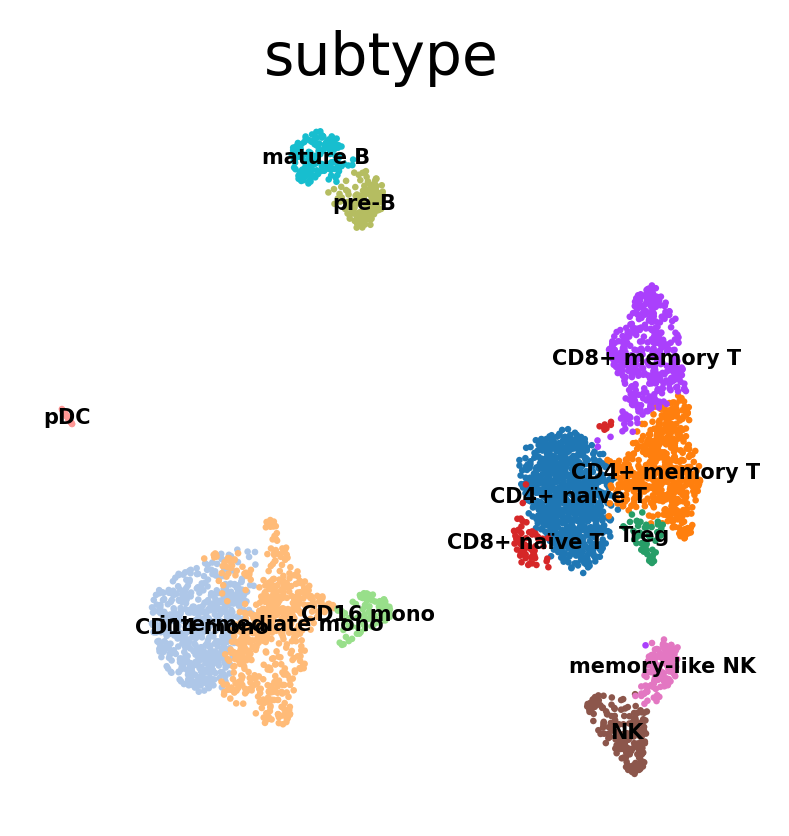

In [3]:
sc.settings.set_figure_params(dpi=150,figsize = (3, 3.1))

sc.pl.umap(PBMCs5k, size=10, color=["subtype"],color_map="viridis",legend_loc="on data", frameon=False, legend_fontsize=5)

### Raw count matrix

Get a dataframe of ADT raw count as the input of `scar`

In [4]:
raw_ADT = PBMCs5k[:, PBMCs5k.var_names.str.endswith('_TotalSeqB')].to_df()

raw_ADT.columns = raw_ADT.columns.str.replace('_TotalSeqB','')

raw_ADT.head()

,CD3,CD4,CD8a,CD11b,CD14,CD15,CD16,CD19,CD20,CD25,...,CD197,CD274,CD278,CD335,PD-1,HLA-DR,TIGIT,IgG1_control,IgG2a_control,IgG2b_control
CCGGGTAGTTCAAACC-1,876.0,968.0,8.0,10.0,8.0,9.0,1.0,3.0,10.0,3.0,...,20.0,2.0,29.0,6.0,6.0,14.0,4.0,3.0,3.0,2.0
CTTTCGGTCCGCAACG-1,516.0,664.0,4.0,4.0,4.0,6.0,0.0,3.0,1.0,2.0,...,15.0,1.0,26.0,5.0,5.0,8.0,1.0,1.0,3.0,0.0
TCTACCGGTGTAAACA-1,666.0,837.0,5.0,10.0,6.0,5.0,1.0,4.0,7.0,4.0,...,30.0,1.0,36.0,2.0,5.0,9.0,1.0,3.0,3.0,2.0
ATAGACCCATAATGCC-1,352.0,709.0,3.0,7.0,8.0,12.0,3.0,4.0,4.0,2.0,...,13.0,2.0,100.0,6.0,12.0,9.0,4.0,2.0,2.0,2.0
TCTATACAGGGTATAT-1,289.0,861.0,7.0,3.0,8.0,4.0,2.0,4.0,9.0,21.0,...,10.0,3.0,31.0,3.0,3.0,11.0,1.0,4.0,4.0,4.0


### Ambient profile

Get a dataframe of ADT ambient profile as the input of `scar`

In [5]:
ambient_profile = PBMCs5k.uns['ambient_profile']

ambient_profile.head()

,ambient_profile
CD3,0.049876
CD4,0.048823
CD8a,0.023453
CD11b,0.083170
CD14,0.107178


<div class="alert alert-info">
    
IMPORTANT

For denoising CITEseq data, we do not recommend running scar with the default setting (i.e., estimating the ambient profile by averaging cells). Instead, we advise calculating the ambient profile by averaging cell-free droplets. Accurately calculating the ambient profile is crucial for precise denoising.

For more details, see an example of [calculating ambient profile](https://scar-tutorials.readthedocs.io/en/latest/tutorials/scAR_tutorial_ambient_profile.html).

scAR allows for denoising a specific subset of genes and samples. To save computational time, it is advisable to use filtered raw counts (e.g., xxx_filtered_feature_bc_matrix.h5).

</div>

## Training

In [6]:
ADT_scar = model(raw_count = raw_ADT,
                 ambient_profile = ambient_profile,  # Providing ambient profile is recommended for CITEseq; in other modes, you can leave this argument as the default value -- None
                 feature_type = 'ADT', # "ADT" or "ADTs" for denoising protein counts in CITE-seq
                 count_model = 'binomial',   # Depending on your data's sparsity, you can choose between 'binomial', 'possion', and 'zeroinflatedpossion'
                )

ADT_scar.train(epochs=500,
               batch_size=64,
               verbose=True
              )

# After training, we can infer the true protein signal
ADT_scar.inference()  # by defaut, batch_size=None, set a batch_size if getting GPU memory issue

2024-08-10 21:06:51|INFO|model|cuda is detected and will be used.
2024-08-10 21:06:51|INFO|VAE|Running VAE using the following param set:
2024-08-10 21:06:51|INFO|VAE|...denoised count type: ADT
2024-08-10 21:06:51|INFO|VAE|...count model: binomial
2024-08-10 21:06:51|INFO|VAE|...num_input_feature: 32
2024-08-10 21:06:51|INFO|VAE|...NN_layer1: 150
2024-08-10 21:06:51|INFO|VAE|...NN_layer2: 100
2024-08-10 21:06:51|INFO|VAE|...latent_space: 15
2024-08-10 21:06:51|INFO|VAE|...dropout_prob: 0.00
2024-08-10 21:06:51|INFO|VAE|...expected data sparsity: 0.90
2024-08-10 21:06:52|INFO|model|kld_weight: 1.00e-05
2024-08-10 21:06:52|INFO|model|learning rate: 1.00e-03
2024-08-10 21:06:52|INFO|model|lr_step_size: 5
2024-08-10 21:06:52|INFO|model|lr_gamma: 0.97


Training: 100%|██████████| 500/500 [02:33<00:00,  3.25it/s, Loss=1.0748e+02]


The denoised counts are saved in `ADT_scar.native_counts` and can be used for downstream analysis.

In [7]:
denoised_ADT = pd.DataFrame(ADT_scar.native_counts.toarray(), index=raw_ADT.index, columns=raw_ADT.columns)

denoised_ADT.head()

,CD3,CD4,CD8a,CD11b,CD14,CD15,CD16,CD19,CD20,CD25,...,CD197,CD274,CD278,CD335,PD-1,HLA-DR,TIGIT,IgG1_control,IgG2a_control,IgG2b_control
CCGGGTAGTTCAAACC-1,865,949,0,0,0,0,0,0,0,0,...,0,0,26,0,4,0,0,0,0,0
CTTTCGGTCCGCAACG-1,494,658,0,0,0,0,0,0,0,0,...,0,0,25,0,4,0,0,0,0,0
TCTACCGGTGTAAACA-1,651,857,0,0,0,0,0,0,0,0,...,0,0,34,0,2,0,0,0,0,0
ATAGACCCATAATGCC-1,358,722,0,0,0,0,0,0,0,4,...,0,0,96,0,8,0,0,0,0,0
TCTATACAGGGTATAT-1,278,861,0,0,0,0,0,0,0,26,...,0,0,32,0,4,0,0,0,0,0


## Visualization

Plot setting

In [8]:
from matplotlib import pylab

params = {'legend.fontsize': 6,
          'legend.title_fontsize': 8,
          'figure.facecolor':"w",
          'figure.figsize': (6, 4.5),
         'axes.labelsize': 6,
         'axes.titlesize':8,
         'axes.linewidth': 0.5,
         'xtick.labelsize':6,
         'ytick.labelsize':6,
         'axes.grid':False,}
pylab.rc('font',**{'family':'serif','serif':['Palatino'],'size':10})
pylab.rcParams.update(params);

sns.set_palette("muted");
sns.set_style("ticks");
sns.despine(offset=4, trim=True);

<Figure size 900x675 with 0 Axes>

### Boxplot of ADT counts per cell type

Prepare a dataframe for visualization

In [13]:
denoised_ADT_stacked = np.log2(denoised_ADT+1).stack().to_frame('log2(ADT+1)').rename_axis(['cells', 'ADTs']).reset_index().set_index('cells')
denoised_ADT_stacked = denoised_ADT_stacked.join(PBMCs5k.obs)
denoised_ADT_stacked['count'] = 'scar-denoised ADT'

raw_ADT_stacked = np.log2(raw_ADT+1).stack().to_frame('log2(ADT+1)').rename_axis(['cells', 'ADTs']).reset_index().set_index('cells')   # log scale for visualization,
raw_ADT_stacked = raw_ADT_stacked.join(PBMCs5k.obs) # Add cell type information
raw_ADT_stacked['count'] = 'raw ADT'

ADTs_stacked = pd.concat([raw_ADT_stacked, denoised_ADT_stacked])
ADTs_stacked.head()

,ADTs,log2(ADT+1),celltype,subtype,count
cells,,,,,
CCGGGTAGTTCAAACC-1,CD3,9.776433,T cells,CD4+ naïve T,raw ADT
CCGGGTAGTTCAAACC-1,CD4,9.920353,T cells,CD4+ naïve T,raw ADT
CCGGGTAGTTCAAACC-1,CD8a,3.169925,T cells,CD4+ naïve T,raw ADT
CCGGGTAGTTCAAACC-1,CD11b,3.459432,T cells,CD4+ naïve T,raw ADT
CCGGGTAGTTCAAACC-1,CD14,3.169925,T cells,CD4+ naïve T,raw ADT


Boxplot visualization of ADT counts per cell type before and after denoising.

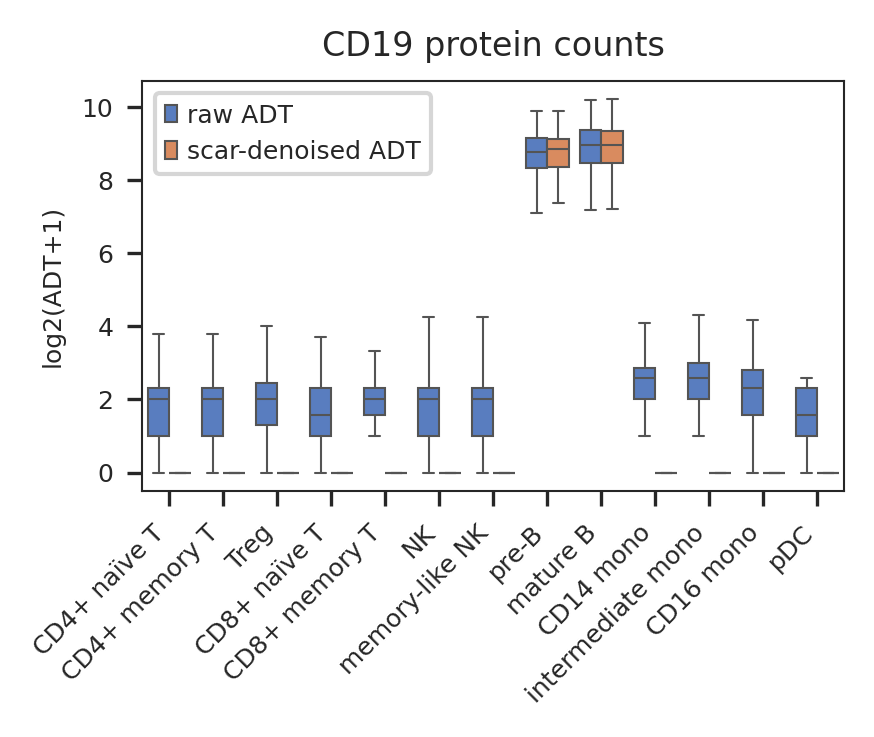

In [14]:
marker = "CD19"
tmp = ADTs_stacked[ADTs_stacked['ADTs']==marker]
plt.figure(figsize=(3, 1.8))

g = sns.boxplot(x="subtype",
                y="log2(ADT+1)",
                data=tmp,
                hue="count",
                hue_order=['raw ADT', 'scar-denoised ADT'],
                orient="v",
                dodge=True,
                width=0.8,
                showfliers=False,
                linewidth=0.5,
           );

g.legend_.set_title('')
g.set(xlabel='',title=f'{marker} protein counts');
g.set_xticklabels(g.get_xticklabels(),rotation=45, ha='right');

CD19 is a B cell specific marker, raw CD19 counts are detected in every cell type, while denoised counts are only observed in B cells.

Similarly, we observed ambient ADTs of other markers and scar can remove these ambient signals but preserve 'true' ADTs.

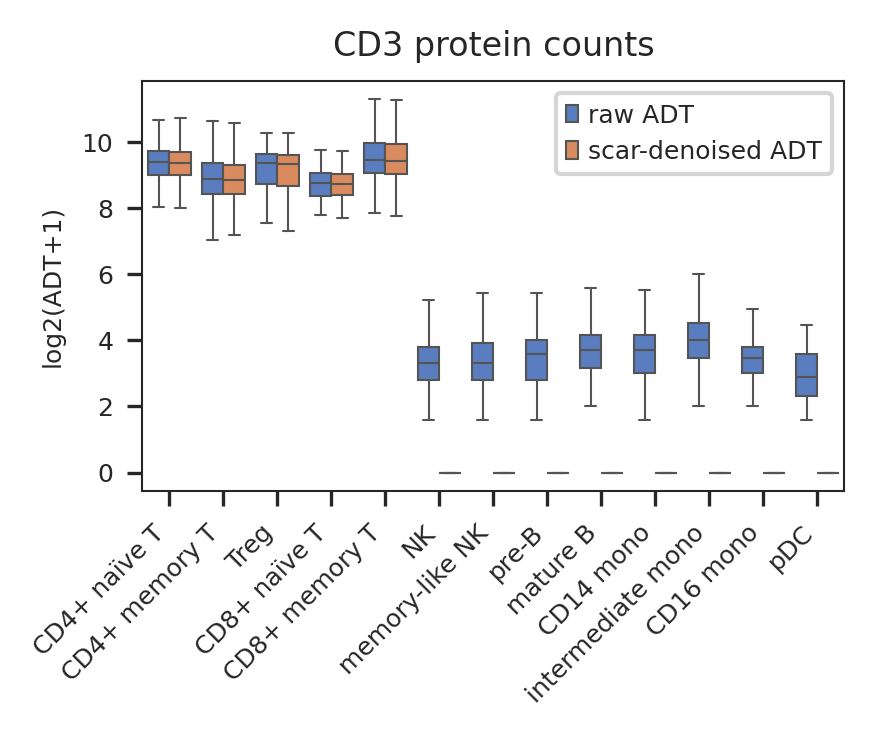

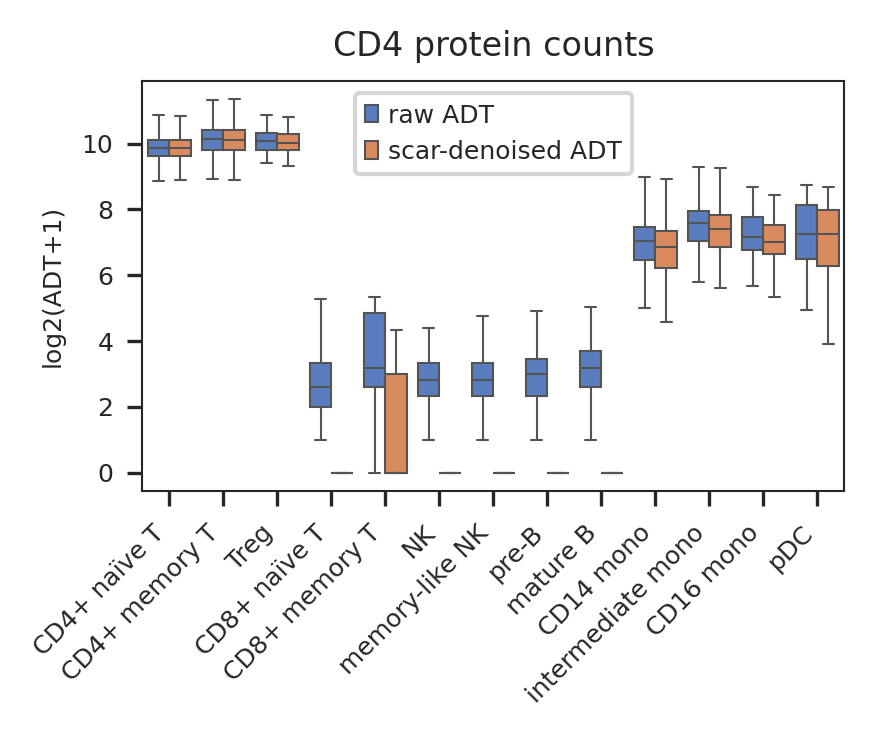

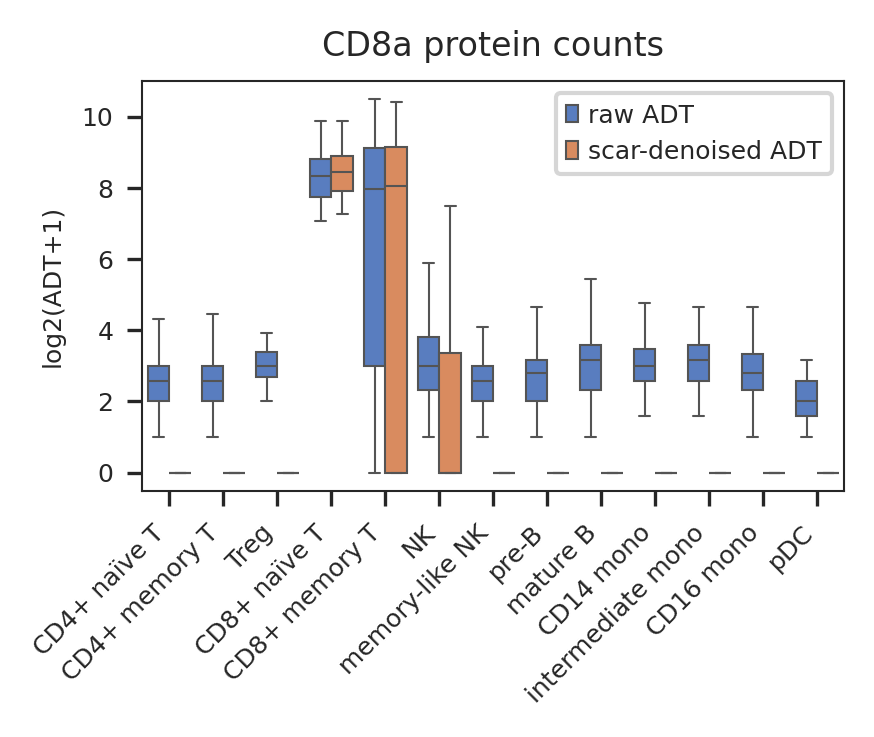

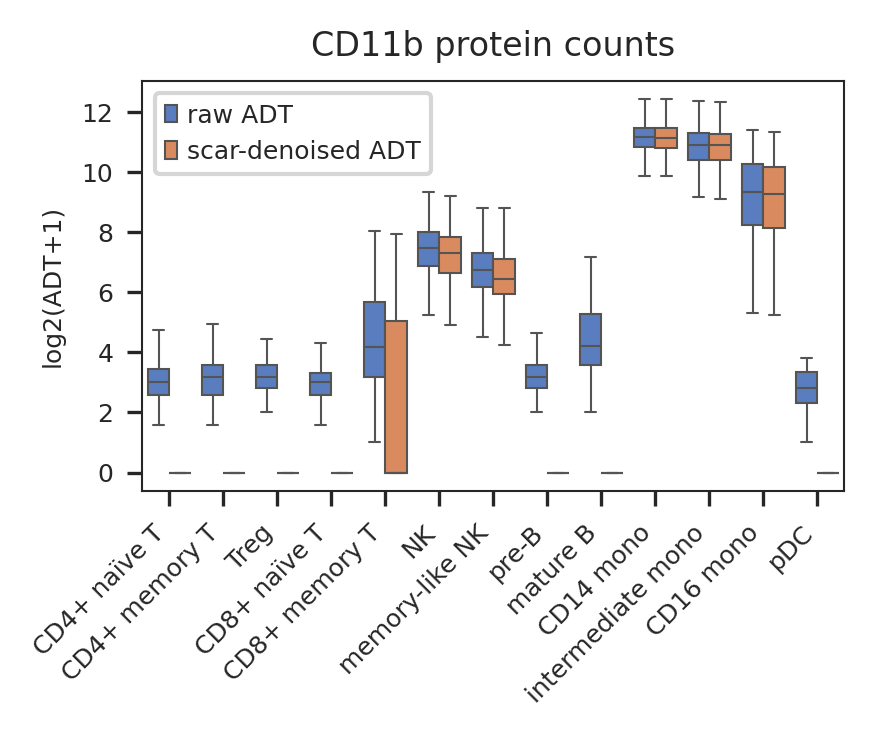

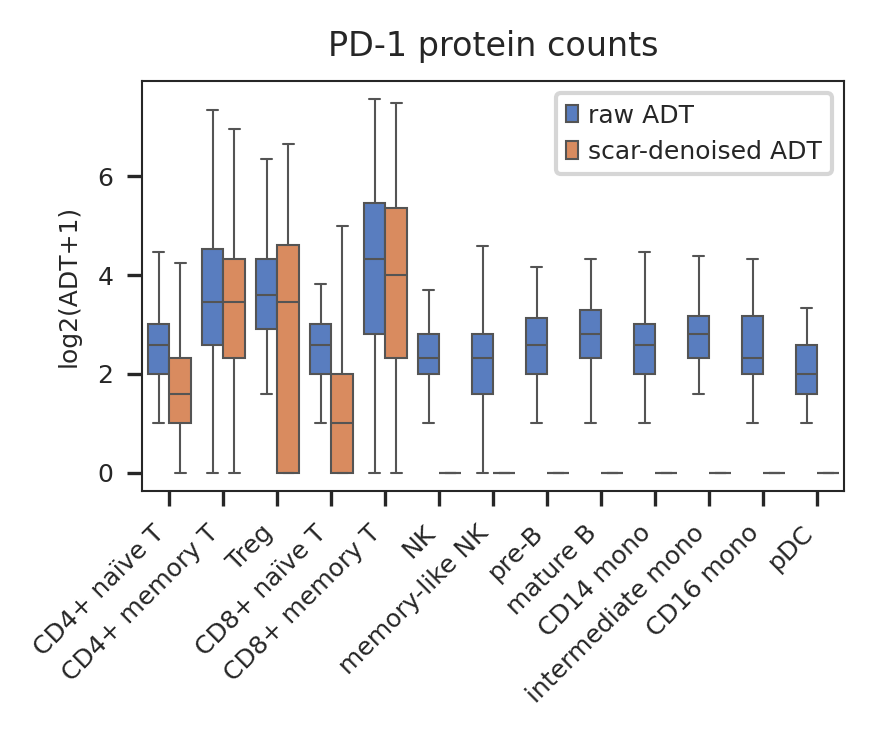

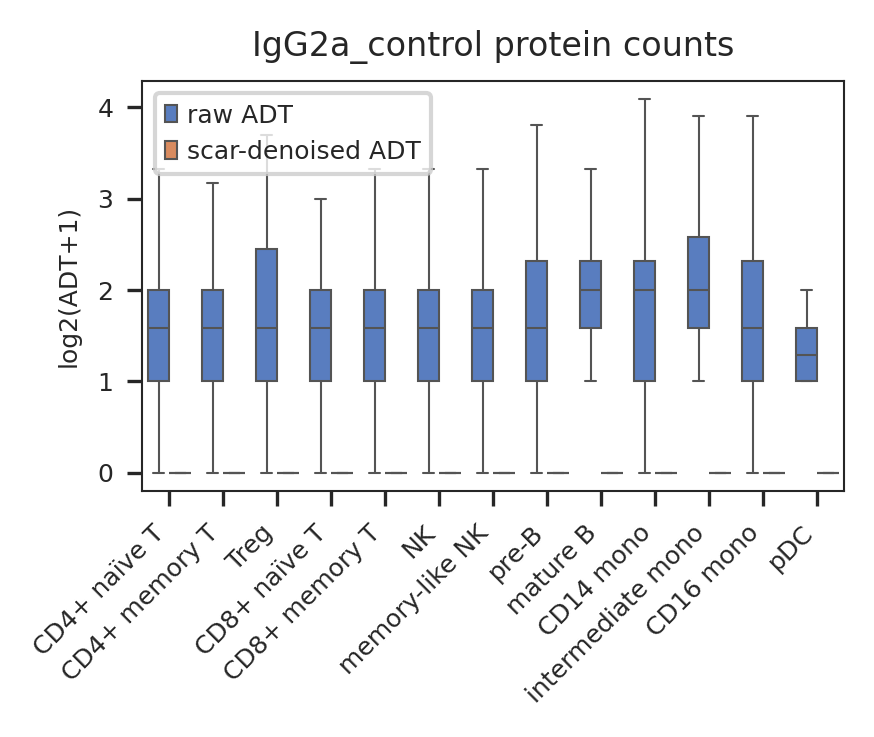

In [15]:
for marker in ["CD3", "CD4", "CD8a", "CD11b", "PD-1", "IgG2a_control"]:
    tmp = ADTs_stacked[ADTs_stacked['ADTs']==marker]
    plt.figure(figsize=(3, 1.8))
    g = sns.boxplot(x="subtype",
                    y="log2(ADT+1)",
                    data=tmp,
                    hue="count",
                    hue_order=['raw ADT', 'scar-denoised ADT'],
                    orient="v",
                    dodge=True,
                    width=0.8,
                    showfliers=False,
                    linewidth=0.5,
               );
    g.legend_.set_title('')
    g.set(xlabel='', title=f'{marker} protein counts');
    g.set_xticklabels(g.get_xticklabels(),rotation=45, ha='right')

### UMAP of ADT and RNA

match ADT name and transcript name

In [16]:
prot2gene = PBMCs5k.uns['prot2gene']

Expression of mRNA

In [17]:
mRNA = PBMCs5k[:, list(prot2gene.values())].to_df()
mRNA.columns = mRNA.columns.astype(str)+'_RNA'

In [18]:
raw_ADT.columns = 'raw_' + raw_ADT.columns.astype(str)
denoised_ADT.columns = 'denoised_' + denoised_ADT.columns.astype(str)
PBMCs5k.obs = PBMCs5k.obs.join(mRNA).join(raw_ADT).join(denoised_ADT)

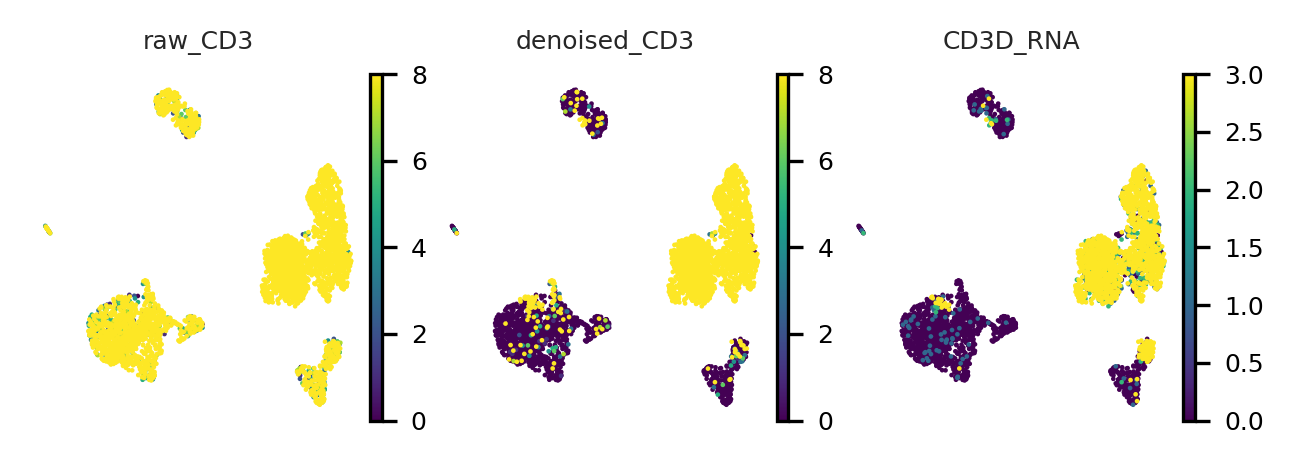

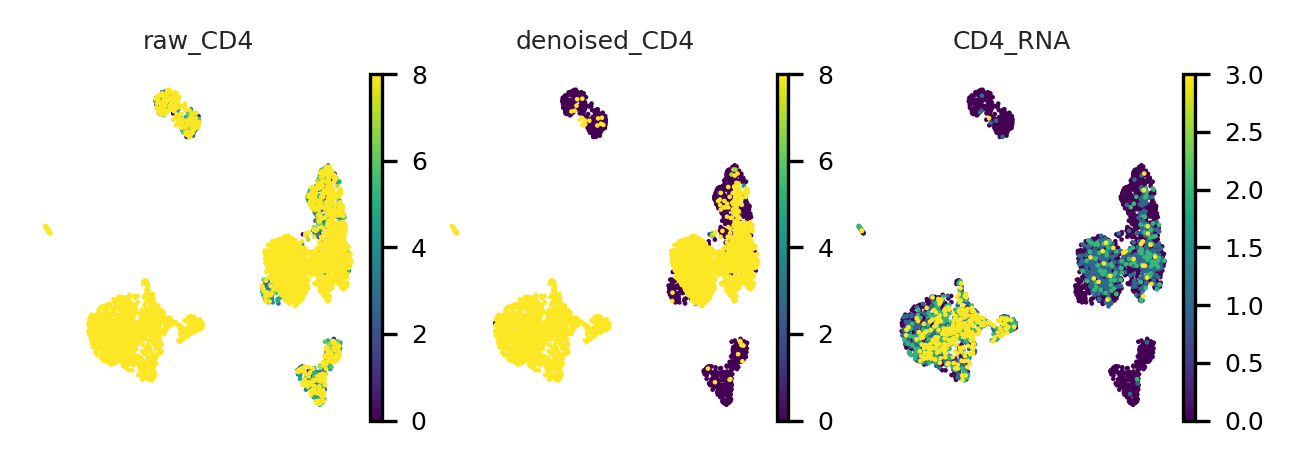

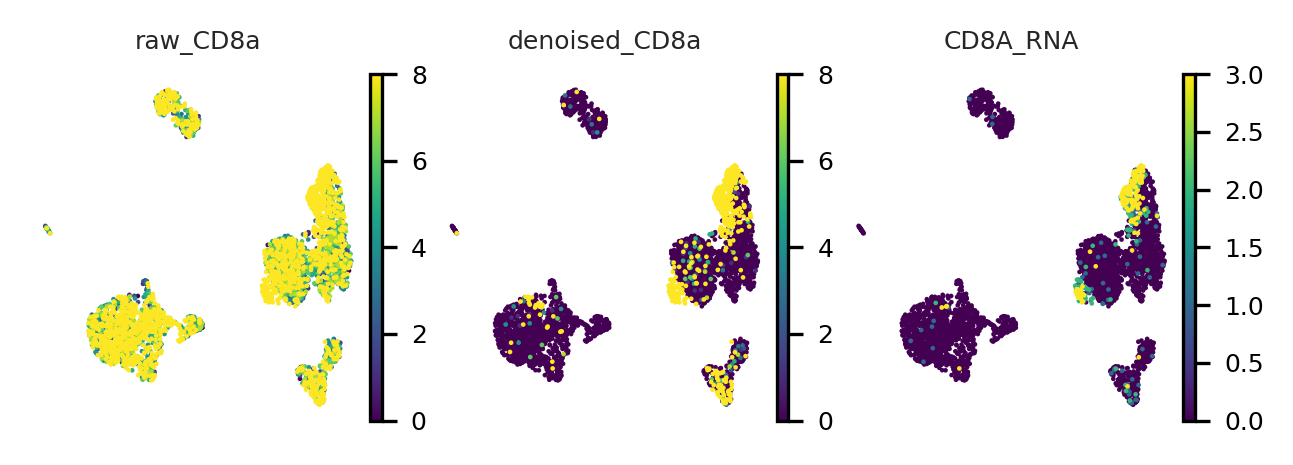

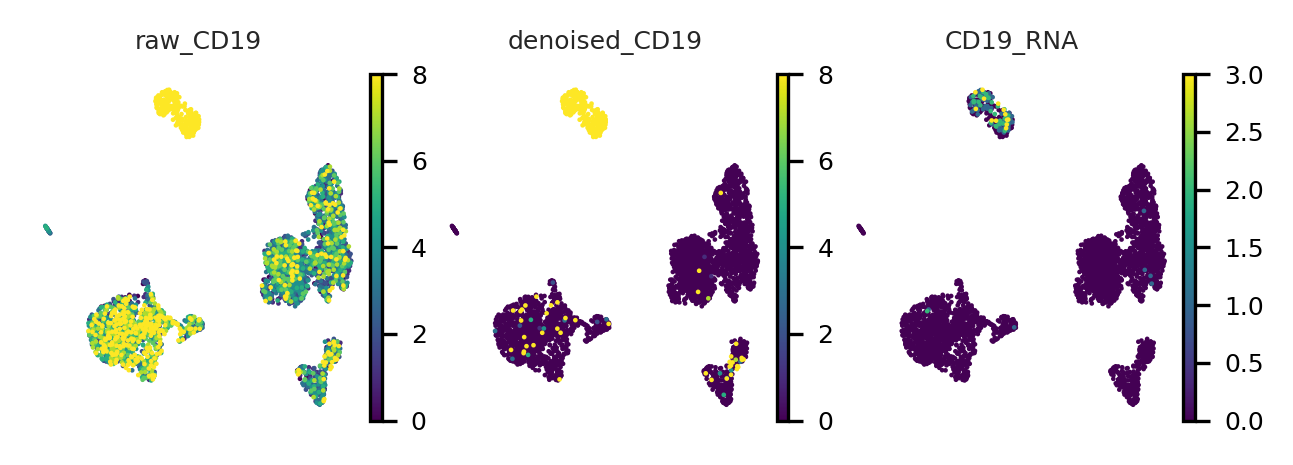

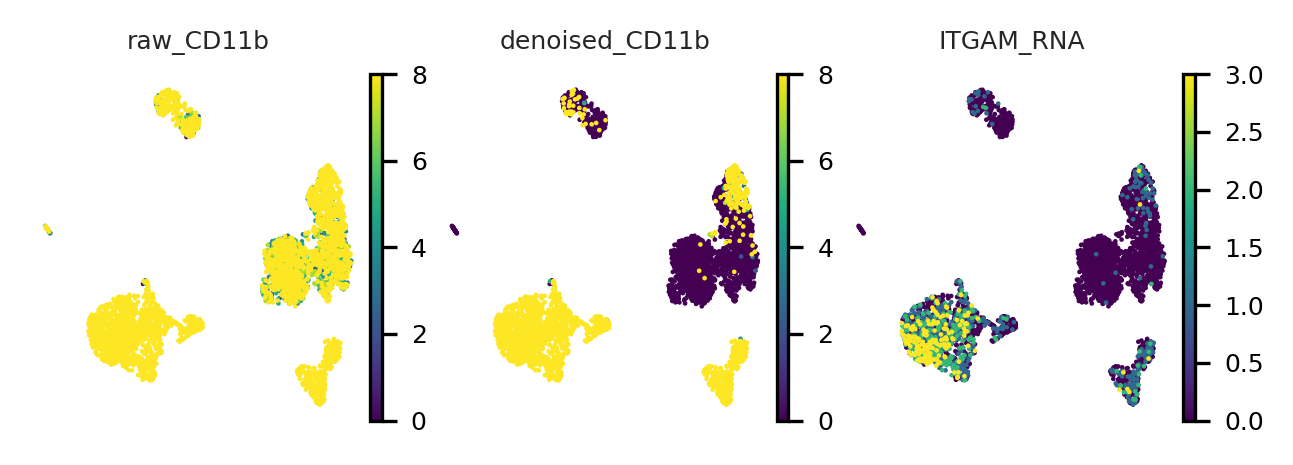

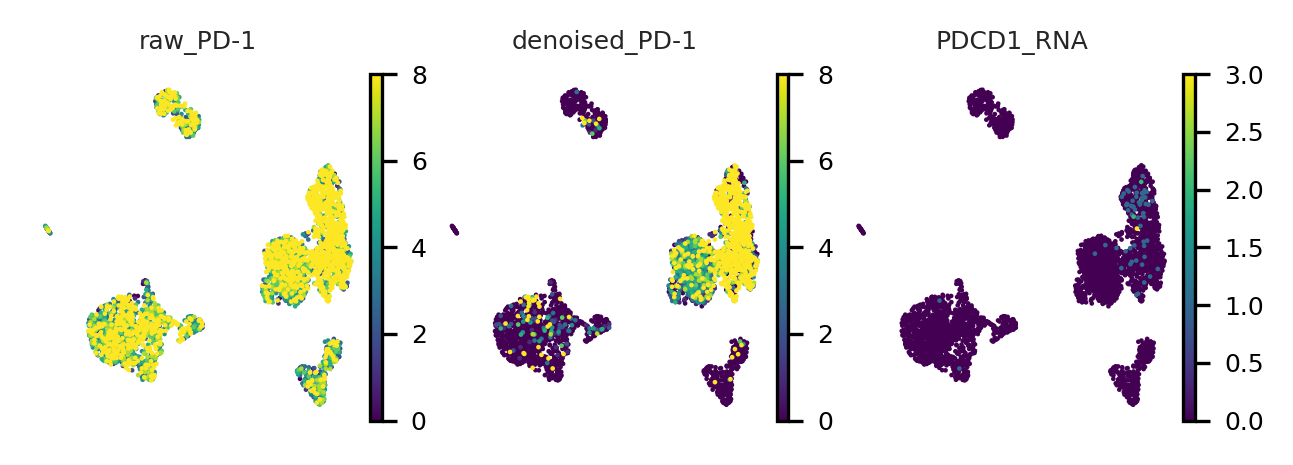

In [19]:
sc.settings.set_figure_params(dpi = 150, figsize = (1.5, 1.5), fontsize = 6)

for marker in ["CD3", "CD4", "CD8a", "CD19", "CD11b", "PD-1"]:
    raw_prot_label = f'raw_{marker}'
    denoised_prot_label = f'denoised_{marker}'
    RNA_label = f'{prot2gene[marker]}_RNA'
    sc.pl.umap(PBMCs5k,
               size = 5,
               color = [raw_prot_label, denoised_prot_label, RNA_label],
               color_map = "viridis",
               frameon = False,
               vmax = [8, 8, 3],
               vmin = 0,
               wspace = 0.1
              )